Summary Statistics:
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-30 12:00:30.000000768     201.957515     116.376337   
min              2021-10-30 00:01:00     -19.500000      -7.800000   
25%              2022-01-29 06:00:45      -2.800000      -0.300000   
50%              2022-04-30 12:00:30       0.300000      -0.100000   
75%              2022-07-30 18:00:15     362.400000     107.000000   
max              2022-10-30 00:00:00    1499.000000     946.000000   
std                              NaN     298.495150     218.652659   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      113.720571     206.643095     198.114691      26.319394   
min       -17.900000       0.000000       0.000000      12.300000   
25%        -3.800000       0.000000       0.000000      23.100000   
50%

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001EB2D422BA0>>
Traceback (most recent call last):
  File "c:\Users\hp\Desktop\matos\10academy\solar-challenge-week1\solar-challenge-week1\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "c:\Users\hp\Desktop\matos\10academy\solar-challenge-week1\solar-challenge-week1\.venv\Lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_daemon_thread.py", line 108, in new_threading_enumerate
    def new_threading_enumerate():
KeyboardInterrupt: 


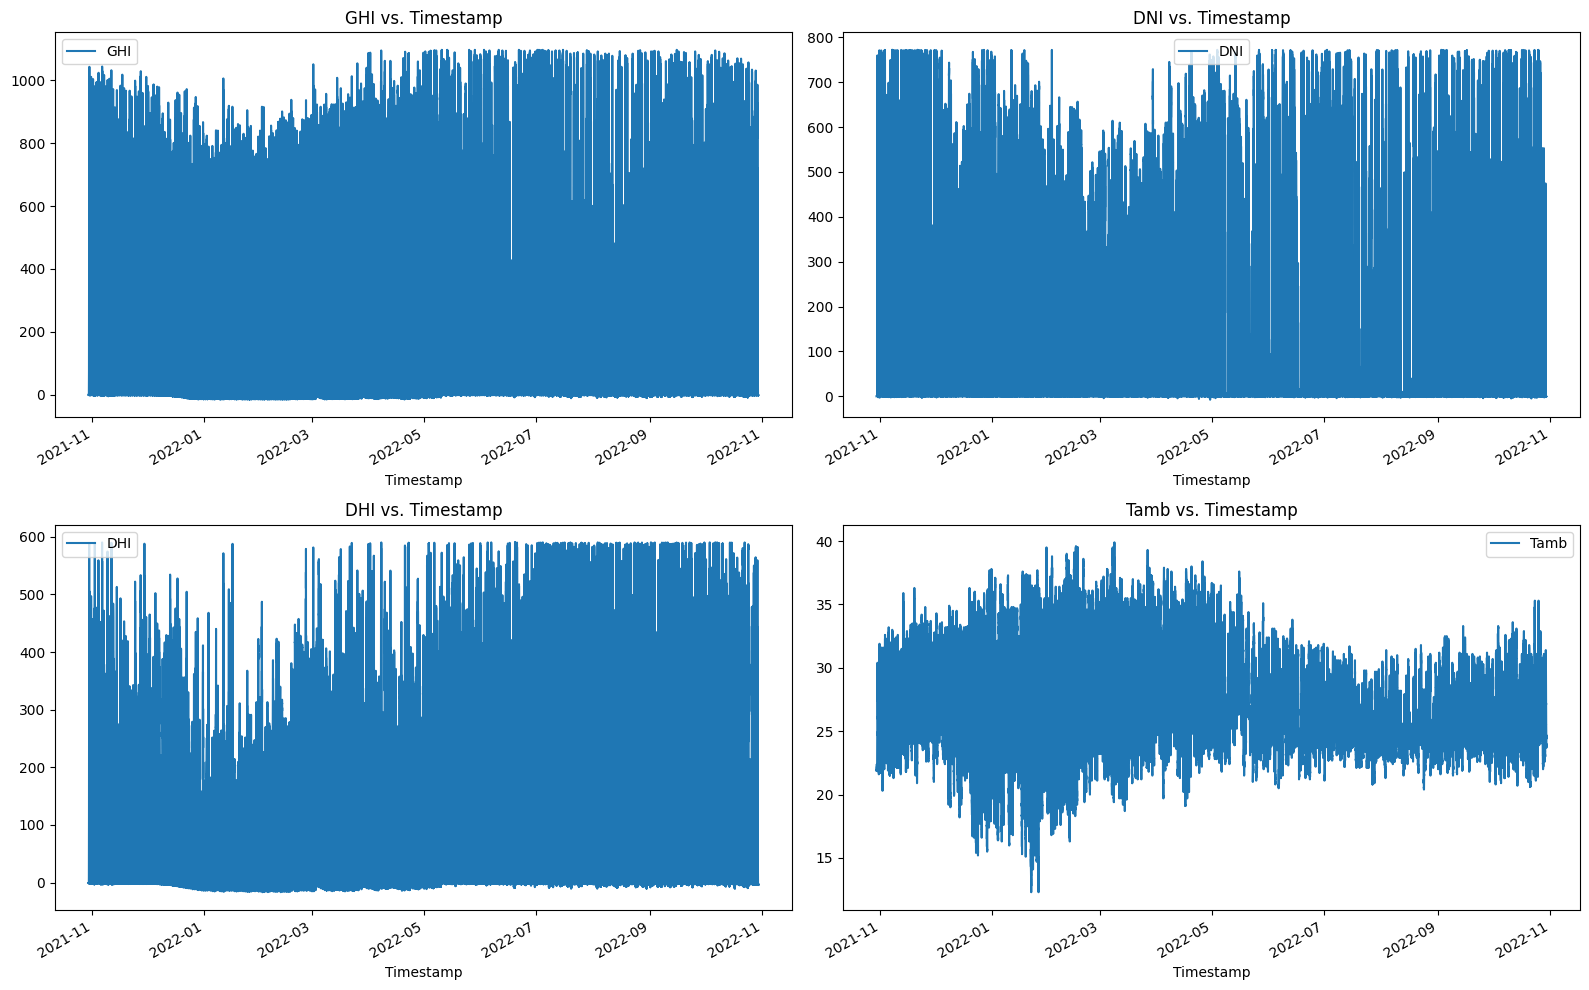

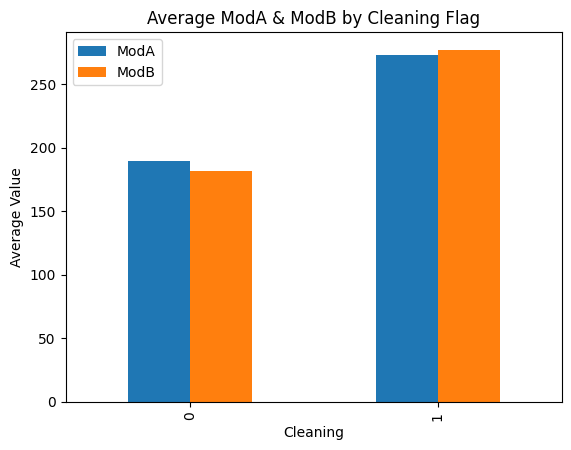

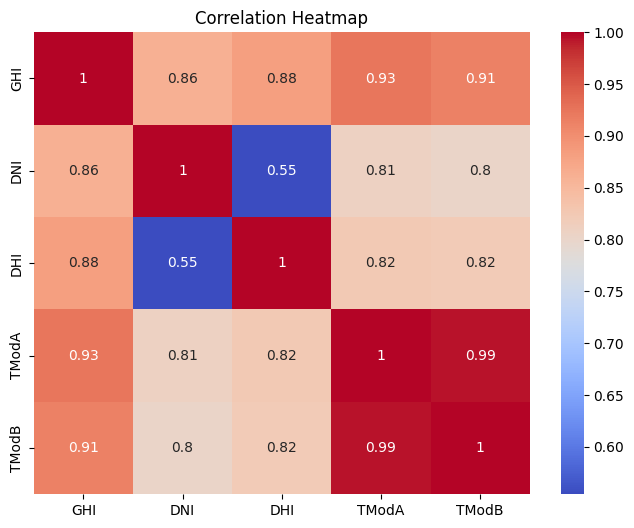

In [ ]:
# Exploratory Data Analysis (EDA) for Solar/Wind Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Load your data into df
# Summary Statistics & Missing-Value Report

df = pd.read_csv('../data/sierraleone-bumbuna.csv', parse_dates=['Timestamp'])

summary_stats = df.describe()
missing_report = df.isna().sum()
n_rows = len(df)
missing_pct = (missing_report / n_rows) * 100
cols_gt5pct_nulls = missing_pct[missing_pct > 5].index.tolist()

print("Summary Statistics:\n", summary_stats)
print("\nMissing Value Report:\n", missing_report)
print("\nColumns with >5% missing values:", cols_gt5pct_nulls)

# Outlier Detection & Basic Cleaning
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
df_z = df[key_cols].apply(stats.zscore)
outlier_mask = (np.abs(df_z) > 3).any(axis=1)
print(f"\nNumber of outlier rows (|Z|>3): {outlier_mask.sum()}")

# Impute missing values in key columns with median
for col in key_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

# Drop rows with outliers in key columns
df_clean = df[~outlier_mask].copy()

# Export cleaned DataFrame to CSV
df_clean.to_csv(f"../data/sierraleone_clean.csv", index=False)

# Time Series Analysis
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
df_clean.plot(x='Timestamp', y='GHI', ax=axs[0,0], title='GHI vs. Timestamp')
df_clean.plot(x='Timestamp', y='DNI', ax=axs[0,1], title='DNI vs. Timestamp')
df_clean.plot(x='Timestamp', y='DHI', ax=axs[1,0], title='DHI vs. Timestamp')
df_clean.plot(x='Timestamp', y='Tamb', ax=axs[1,1], title='Tamb vs. Timestamp')
plt.tight_layout()
plt.show()

# Cleaning Impact
if 'Cleaning' in df_clean.columns:
    cleaning_group = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()
    cleaning_group.plot(kind='bar', title='Average ModA & ModB by Cleaning Flag')
    plt.ylabel('Average Value')
    plt.show()

# Correlation & Relationship Analysis
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatter plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=axs[0,0])
axs[0,0].set_title('WS vs. GHI')
sns.scatterplot(data=df_clean, x='WSgust', y='GHI', ax=axs[0,1])
axs[0,1].set_title('WSgust vs. GHI')
sns.scatterplot(data=df_clean, x='WD', y='GHI', ax=axs[1,0])
axs[1,0].set_title('WD vs. GHI')
sns.scatterplot(data=df_clean, x='RH', y='Tamb', ax=axs[1,1])
axs[1,1].set_title('RH vs. Tamb')
plt.tight_layout()
plt.show()

# Wind Rose / Radial Bar Plot

from windrose import WindroseAxes

try:
    ax = WindroseAxes.from_ax()
    ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_title('Wind Rose')
    plt.show()
except Exception as e:
    print("Error plotting wind rose:", e)
    print("Ensure the windrose package is installed.")

# Histograms
df_clean['GHI'].hist(bins=30, alpha=0.7)
plt.title('Histogram of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.show()

df_clean['WS'].hist(bins=30, alpha=0.7)
plt.title('Histogram of WS')
plt.xlabel('WS')
plt.ylabel('Frequency')
plt.show()

# Temperature Analysis: RH vs. Tamb and RH vs. GHI
sns.scatterplot(data=df_clean, x='RH', y='Tamb')
plt.title('RH vs. Tamb')
plt.show()

sns.scatterplot(data=df_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

# Bubble Chart: GHI vs. Tamb, bubble size = RH or BP
plt.figure(figsize=(10,6))
bubble_size = df_clean['RH'] if 'RH' in df_clean.columns else df_clean['BP']
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=bubble_size, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs. Tamb (Bubble size = RH or BP)')
plt.show()



these are the references of the above process in each section 

### Summary Statistics & Missing Values

The summary statistics above provide an overview of the central tendency and spread of each numeric variable. Columns with more than 5% missing values are flagged for further attention. High missingness may indicate sensor issues or data collection gaps.

**Reference:**  
- [Pandas describe() documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)
- [Handling Missing Data in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)


### Outlier Detection and Data Cleaning

Outliers were detected using Z-scores (|Z| > 3), a common statistical method for identifying values that deviate significantly from the mean. Rows with outliers in key columns (GHI, DNI, DHI, ModA, ModB, WS, WSgust) were removed to ensure data quality. Missing values in these columns were imputed with the median to minimize bias.

**Reference:**  
- [Z-score Outlier Detection](https://en.wikipedia.org/wiki/Standard_score)
- [Imputing Missing Values](https://scikit-learn.org/stable/modules/impute.html)

### Time Series Analysis

The time series plots of GHI, DNI, DHI, and Tamb against Timestamp reveal daily and seasonal patterns. Peaks in solar irradiance typically occur around midday, while temperature fluctuations follow expected diurnal cycles. Any anomalies or missing data periods are visually apparent.

**Reference:**  
- [Matplotlib Time Series Plotting](https://matplotlib.org/stable/gallery/lines_bars_and_markers/date_demo.html)

### Impact of Cleaning

Grouping by the 'Cleaning' flag and comparing average ModA and ModB values helps assess the effect of panel cleaning on sensor readings. A noticeable increase post-cleaning suggests cleaning improves panel efficiency.

**Reference:**  
- [GroupBy in Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)

### Correlation and Relationship Analysis

The correlation heatmap shows relationships between key variables. Strong positive correlations between GHI, DNI, and DHI are expected, as they all measure solar irradiance. Scatter plots further illustrate relationships between wind speed, direction, humidity, and solar/temperature variables.

**Reference:**  
- [Seaborn Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
- [Seaborn Scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

### Wind and Distribution Analysis

The wind rose visualizes the distribution of wind speed and direction, which is important for wind energy assessment. Histograms show the frequency distribution of GHI and WS, helping to identify skewness or unusual patterns.

**Reference:**  
- [Windrose Python Package](https://windrose.readthedocs.io/en/latest/)
- [Matplotlib Histogram](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)

### Temperature and Humidity Analysis

Scatter plots and bubble charts reveal how relative humidity (RH) influences temperature (Tamb) and solar irradiance (GHI). Larger bubbles indicate higher RH or BP, helping to visualize multi-dimensional relationships.

**Reference:**  
- [Bubble Chart in Matplotlib](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html)